In [1]:
!pip install cartopy
import cartopy
!pip install herbie-data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install metpy
from metpy.io import parse_metar_file, parse_metar_to_dataframe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.calc import wind_components
from metpy.plots import StationPlot, sky_cover

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.4/424.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 30.3 MB/s eta 0:00:00


In [14]:
##### Instructors code for this lab project #####
def retrieve_metar_data(start_time, end_time=None, extent=None, data_types='all', report_type=3,
                        time_buffer=None):
    """An alternative method that fetches all available AWOS data.

    start_time (pd.Timestamp): Start time
    end_time (pd.Timestamp): End time
    extent (list): [min_lon, max_lon, min_lat, max_lat]
    data_types (str): What type of data to fetch. Supports 'all' or 'metar'
    report_type (int): Frequency of observations (see docs below)
    time_buffer (pd.TimeDelta): The time padding before/after start/end


    https://mesonet.agron.iastate.edu/request/download.phtml?network=CO_ASOS

    """

    thisurl = f"http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?data={data_types}&tz=Etc/UTC&format=comma&latlon=yes&"

    if end_time == None:
        end_time = start_time
    if time_buffer != None:
        start_time = start_time - time_buffer
        end_time = end_time + time_buffer

    thisurl += start_time.strftime("year1=%Y&month1=%m&day1=%d&hour1=%H&minute1=%M&")
    thisurl += end_time.strftime("year2=%Y&month2=%m&day2=%d&hour2=%H&minute2=%M&")
    thisurl += f"report_type={report_type}&"

    print(f"Retrieving: {start_time} ----> {end_time}")
    print(thisurl)
    df = pd.read_csv(thisurl, skiprows=5)

    return format_data(df, extent=extent)

def format_data(data, extent=None):
    """ Pulls extent and changes data types to numeric. """

    min_lon, max_lon, min_lat, max_lat = extent
    if extent is not None:
        data = data.loc[(data['lon'] >= min_lon) & (data['lon'] <= max_lon) & (data['lat'] >= min_lat) & (data['lat'] <= max_lat)]

    numeric_cols = ["tmpf", "dwpf", "relh", 'sknt', 'alti', 'vsby', 'mslp', 'p01i', 'gust', 'snowdepth']
    df_copy = data.copy(deep=True)
    df_copy['valid'] = df_copy['valid'].astype("datetime64[ns]")

    for col in numeric_cols:
        if col in df_copy.columns:
            df_copy[col] = pd.to_numeric(df_copy[col], errors="coerce", downcast="float")

    return df_copy.set_index('station')


In [36]:
def wx_station_plot():
    date=input("Input date in form: yyyy-mm-dd")
    time=input("Input time in form: hh:mm")
    t_stamp=date+" "+time
    timestamp = pd.Timestamp(t_stamp)
    df = retrieve_metar_data(timestamp,
                         extent=[-125, -60, 23, 50],
                         time_buffer=pd.Timedelta("10min"))
    y=int(t_stamp[:4])
    mo=int(t_stamp[5:7])
    rand_metar = df.iloc[13]['metar']
    parse_metar_to_dataframe(rand_metar, year=y, month=mo)

    met = df['metar'].values
    all_met = []
    for i, m in enumerate(met):
        all_met.append(parse_metar_to_dataframe(m, year=y, month=mo))

    df_m = pd.concat(all_met)

    df_m['longitude'] = df['lon'].values
    df_m['latitude'] = df['lat'].values
    lcc_proj = ccrs.LambertConformal(central_longitude=-95,
                             central_latitude=35,
                             standard_parallels=[35])

    pc_proj = ccrs.PlateCarree()

    coarse_data = reduce_data_density(data=df_m, resolution=120000)

    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": lcc_proj})

    ax.add_feature(cfeature.LAND.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.LAKES.with_scale('50m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.set_extent((-120, -73, 23, 50))

    sp = StationPlot(ax, coarse_data['longitude'].values, coarse_data['latitude'].values,
                          clip_on=True, transform=pc_proj, spacing=8, fontsize=8)

    sp.plot_parameter('NW', coarse_data['air_temperature'].values, color='red', fontsize=8)
    sp.plot_parameter('NE', coarse_data['dew_point_temperature'].values, color='green', fontsize=8)
    sp.plot_symbol('C', coarse_data['cloud_coverage'].values, sky_cover, fontsize=8)
    sp.plot_barb(coarse_data['eastward_wind'].values, coarse_data['northward_wind'].values)

Input date in form: yyyy-mm-dd2025-05-03
Input time in form: hh:mm00:00
Retrieving: 2025-05-02 23:50:00 ----> 2025-05-03 00:10:00
http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?data=all&tz=Etc/UTC&format=comma&latlon=yes&year1=2025&month1=05&day1=02&hour1=23&minute1=50&year2=2025&month2=05&day2=03&hour2=00&minute2=10&report_type=3&


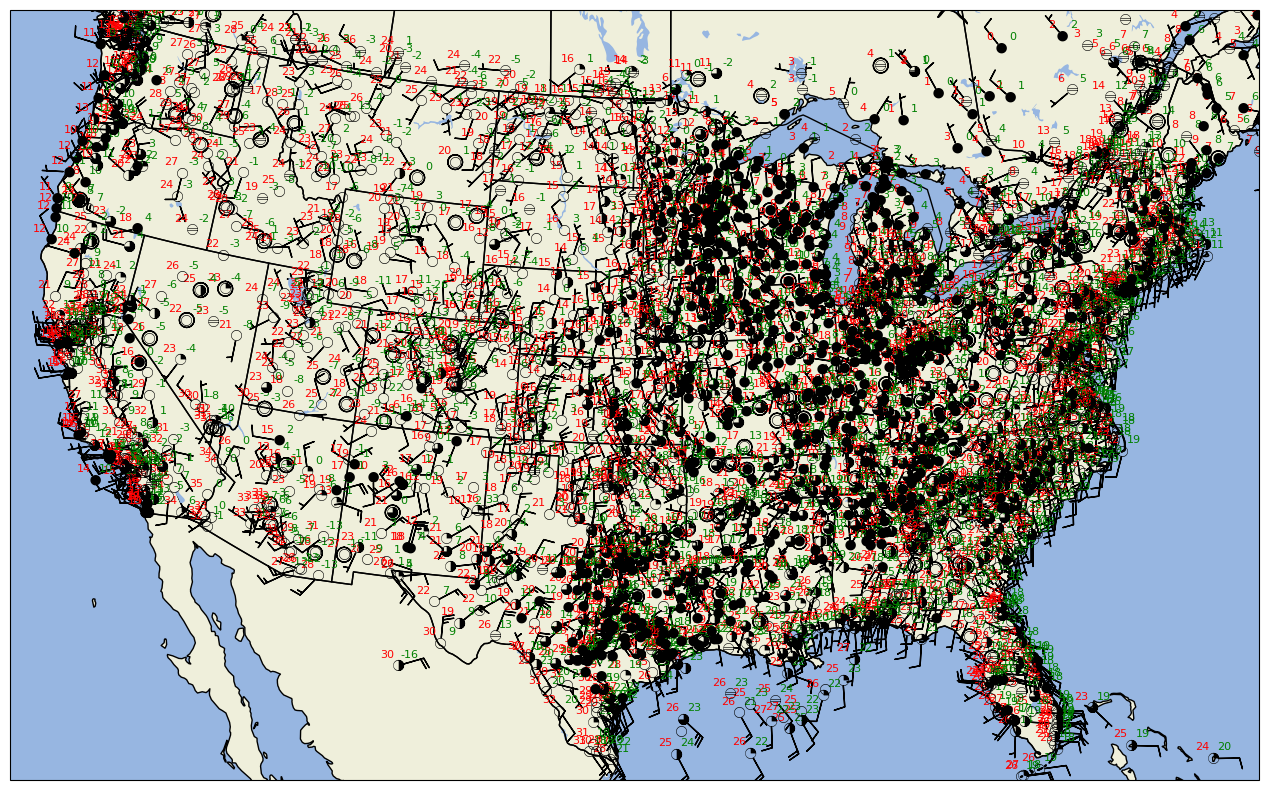

In [37]:
wx_station_plot()